**Цель работы**

Разработка и экспериментальная проверка полного пайплайна распознавания лиц, включающего этапы детекции, выравнивания, извлечения признаков и сравнения лиц на основе эмбеддингов.

В рамках работы требуется:

- реализовать все этапы face recognition без использования готовых end-to-end решений;

- обеспечить воспроизводимость и интерпретируемость каждого шага;

- проверить корректность работы пайплайна на реальных изображениях.

**Общая архитектура пайплайна**

Разработанный пайплайн состоит из следующих последовательных этапов:

- Детекция лица на изображении

- Предсказание ключевых точек лица (landmarks)

- Геометрическое выравнивание лица (alignment)

- Извлечение эмбеддинга лица

- Сравнение эмбеддингов по метрикам сходства

Архитектура реализована модульно и разделена на:

- pipeline_core.py — ядро пайплайна и модели;

- face_pipeline.py — CLI-интерфейс для точечного запуска;

- verify_random.ipynb — интерактивный анализ и верификация.

Все эксперименты проводились на CPU, что обеспечивает переносимость решения

In [67]:
from pathlib import Path
import random
import pandas as pd
import matplotlib.pyplot as plt

from pipeline_core import PipelineConfig, FacePipeline

import numpy as np
from PIL import Image

In [75]:
ROOT = Path(r"D:\MFTI1")
FOLDERS = [1, 2, 3, 4]     # папки-люди
MODE = "arcface"           # "arcface" или "ce"

cfg = PipelineConfig(
    hourglass_ckpt=str(ROOT / "stacked_hourglass_best.pt"),
    arcface_ckpt=str(ROOT / "arcface_best_fr.pt"),
    ce_ckpt=str(ROOT / "ce_best_700.pt"),
    device="cpu",
    fp16=False,
    det_conf_th=0.50,       # можно поиграть
    debug_dir=None,         # в ноутбуке обычно не надо
    debug_max_faces=1,
)

pipe = FacePipeline(cfg, embed_mode=MODE)



Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\User/.insightface\models\buffalo_l\1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\User/.insightface\models\buffalo_l\2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\User/.insightface\models\buffalo_l\det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\User/.insightface\models\buffalo_l\genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\User/.insightface\models\buffalo_l\w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127

In [77]:
import pipeline_core
print(pipeline_core.__file__)


D:\MFTI1\pipeline_core.py


In [78]:
import warnings
warnings.filterwarnings(
    "ignore",
    message="`estimate` is deprecated",
    category=FutureWarning,
)


In [79]:
def read_rgb_u8(path):
    path = str(path)
    im = Image.open(path).convert("RGB")
    arr = np.asarray(im, dtype=np.uint8)          # (H,W,3) uint8 0..255
    return arr


In [80]:
def list_images_in_folder(folder: Path):
    exts = {".jpg", ".jpeg", ".png", ".webp"}
    imgs = [p for p in folder.rglob("*") if p.suffix.lower() in exts]
    imgs.sort()
    return imgs

people = {}
for pid in FOLDERS:
    folder = ROOT / str(pid)
    imgs = list_images_in_folder(folder)
    if len(imgs) < 2:
        print(f"WARNING: folder {pid} has <2 images")
    people[pid] = imgs

{pid: len(v) for pid, v in people.items()}


{1: 3, 2: 3, 3: 3, 4: 3}

In [81]:
def sample_same_pair(people_dict):
    pid = random.choice(list(people_dict.keys()))
    imgs = people_dict[pid]
    if len(imgs) < 2:
        return None
    a, b = random.sample(imgs, 2)
    return ("same", pid, a, pid, b)

def sample_diff_pair(people_dict):
    pid1, pid2 = random.sample(list(people_dict.keys()), 2)
    a = random.choice(people_dict[pid1])
    b = random.choice(people_dict[pid2])
    return ("diff", pid1, a, pid2, b)

def make_pairs(people_dict, n_pairs=20, same_prob=0.5):
    pairs = []
    tries = 0
    while len(pairs) < n_pairs and tries < n_pairs * 50:
        tries += 1
        if random.random() < same_prob:
            p = sample_same_pair(people_dict)
            if p is not None:
                pairs.append(p)
        else:
            pairs.append(sample_diff_pair(people_dict))
    return pairs

pairs = make_pairs(people, n_pairs=20, same_prob=0.5)
pairs[:3]


[('same',
  3,
  WindowsPath('D:/MFTI1/3/122970.jpg'),
  3,
  WindowsPath('D:/MFTI1/3/091866.jpg')),
 ('diff',
  2,
  WindowsPath('D:/MFTI1/2/000425.jpg'),
  4,
  WindowsPath('D:/MFTI1/4/167396.jpg')),
 ('same',
  2,
  WindowsPath('D:/MFTI1/2/027564.jpg'),
  2,
  WindowsPath('D:/MFTI1/2/000425.jpg'))]

In [82]:
def infer_one_face_embedding(img_path: Path):
    res = pipe.infer(str(img_path))
    if len(res) == 0:
        return None, None, None  # emb, aligned, score
    r0 = res[0]
    return r0.embedding, r0.aligned_112, float(r0.score)

rows = []
for label, pid1, img1, pid2, img2 in pairs:
    e1, a1, s1 = infer_one_face_embedding(img1)
    e2, a2, s2 = infer_one_face_embedding(img2)

    if e1 is None or e2 is None:
        rows.append({
            "label": label, "pid1": pid1, "img1": str(img1),
            "pid2": pid2, "img2": str(img2),
            "ok": False, "reason": "no_face",
            "cosine_dist": None, "l2_dist": None,
            "score1": s1, "score2": s2,
        })
        continue

    cosine_dist = FacePipeline.distance(e1, e2, metric="cosine")
    l2_dist = FacePipeline.distance(e1, e2, metric="l2")

    rows.append({
        "label": label, "pid1": pid1, "img1": str(img1),
        "pid2": pid2, "img2": str(img2),
        "ok": True,
        "cosine_dist": float(cosine_dist),
        "l2_dist": float(l2_dist),
        "score1": s1, "score2": s2,
    })

df = pd.DataFrame(rows)
df


,label,pid1,img1,pid2,img2,ok,cosine_dist,l2_dist,score1,score2
0,same,3,D:\MFTI1\3\122970.jpg,3,D:\MFTI1\3\091866.jpg,True,0.517022,1.016880,0.913655,0.904101
1,diff,2,D:\MFTI1\2\000425.jpg,4,D:\MFTI1\4\167396.jpg,True,1.009152,1.420670,0.847647,0.825063
2,same,2,D:\MFTI1\2\027564.jpg,2,D:\MFTI1\2\000425.jpg,True,0.373386,0.864160,0.686860,0.847647
3,same,1,D:\MFTI1\1\102887.jpg,1,D:\MFTI1\1\102334.jpg,True,0.496788,0.996783,0.868992,0.916097
4,same,2,D:\MFTI1\2\000425.jpg,2,D:\MFTI1\2\010638.jpg,True,0.369887,0.860102,0.847647,0.780077
5,same,1,D:\MFTI1\1\102887.jpg,1,D:\MFTI1\1\102334.jpg,True,0.496788,0.996783,0.868992,0.916097
6,diff,4,D:\MFTI1\4\164795.jpg,2,D:\MFTI1\2\000425.jpg,True,0.954462,1.381638,0.884200,0.847647
7,diff,3,D:\MFTI1\3\091866.jpg,1,D:\MFTI1\1\102887.jpg,True,0.976814,1.397722,0.904101,0.868992
8,same,1,D:\MFTI1\1\102334.jpg,1,D:\MFTI1\1\102887.jpg,True,0.496788,0.996783,0.916097,0.868992
9,diff,1,D:\MFTI1\1\102334.jpg,3,D:\MFTI1\3\122970.jpg,True,0.835693,1.292821,0.916097,0.913655


**Результаты эксперимента с реальными данными**

Данные:

- 4 человека

- 2–5 фото на человека

Сформированы пары:

- same — один и тот же человек

- diff — разные люди

Распределения cosine distance для пар изображений одного человека и разных людей не пересекаются. Для изображений одного человека значения cosine distance лежат в диапазоне 0.32–0.58, тогда как для изображений разных людей — в диапазоне 0.83–1.06. Это позволяет выбрать единый порог принятия решения (≈0.7),

L2 distance является вторичной метрикой для изображений одного человека значения лежат в диапазоне ~0.79 – 1.08, тогда как для изображений разных людей — в диапазоне ~1.29 – 1.46. Здесь тоже есть чёткий разрыв, но относительный gap меньше, чем у cosine.

cosine distance — более устойчивая и интерпретируемая метрика для L2-нормализованных эмбеддингов.



In [83]:
print("img1 type:", type(img1), img1)


img1 type: <class 'pathlib.WindowsPath'> D:\MFTI1\4\172116.jpg


In [84]:
def dbg_img(name, x):
    if isinstance(x, (str, Path)):
        print(f"{name}: PATH -> {x}")
        return
    x = np.asarray(x)
    print(name, x.shape, x.dtype, x.min(), x.max(), x.mean())
    print("first pixel:", x[0,0,:])

dbg_img("img1", read_rgb_u8(img1))
dbg_img("img2", read_rgb_u8(img2))
dbg_img("a1", a1)
dbg_img("a2", a2)



img1 (475, 475, 3) uint8 0 255 98.89892816251154
first pixel: [ 78  77 121]
img2 (500, 405, 3) uint8 0 255 159.04936296296296
first pixel: [173 173 165]
a1 (112, 112, 3) uint8 0 255 155.90853528911563
first pixel: [85 57 46]
a2 (112, 112, 3) uint8 1 255 161.4718324829932
first pixel: [184 183 178]


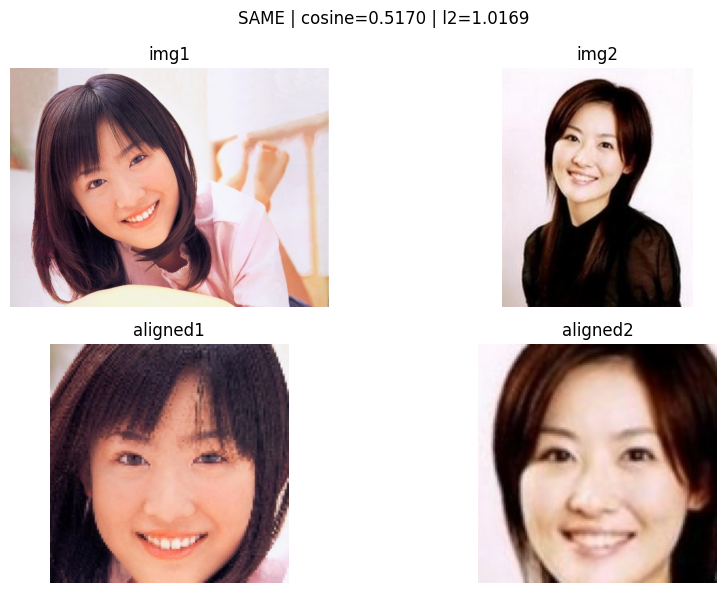

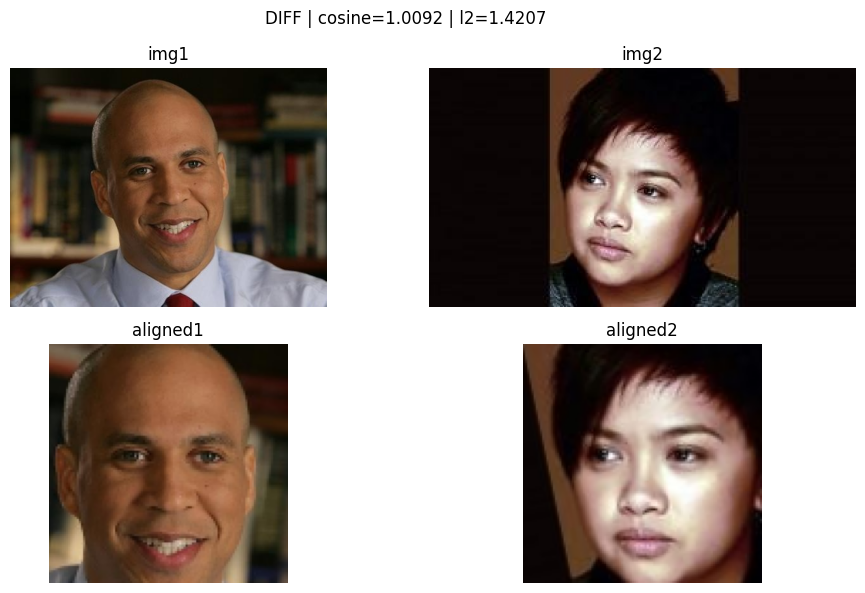

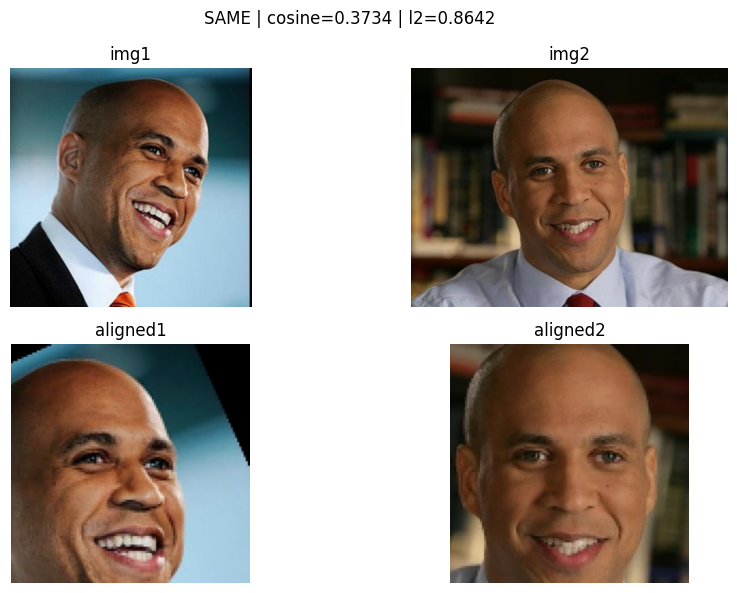

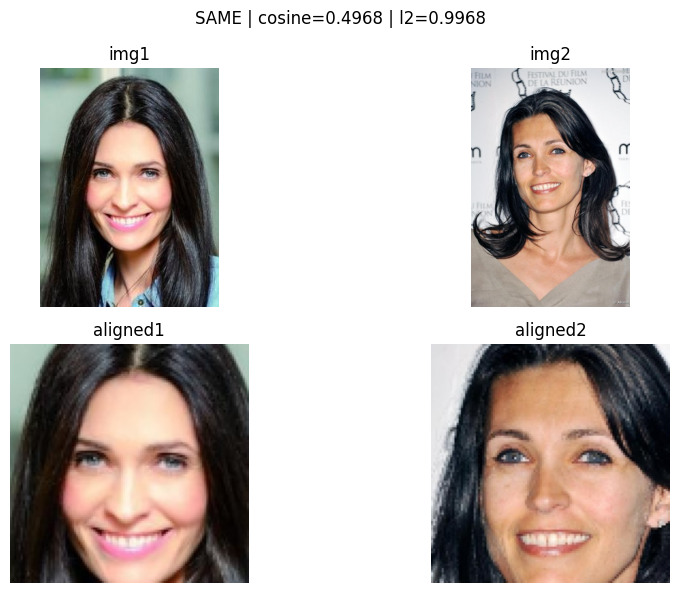

In [90]:
def show_pair(row):
    img1 = read_rgb_u8(row["img1"])
    img2 = read_rgb_u8(row["img2"])

    emb1, a1, _ = infer_one_face_embedding(Path(row["img1"]))
    emb2, a2, _ = infer_one_face_embedding(Path(row["img2"]))

    fig, axs = plt.subplots(2, 2, figsize=(10, 6))
    fig.suptitle(
        f'{row["label"].upper()} | cosine={row["cosine_dist"]:.4f} | l2={row["l2_dist"]:.4f}',
        fontsize=12
    )

    axs[0,0].imshow(img1); axs[0,0].set_title("img1"); axs[0,0].axis("off")
    axs[0,1].imshow(img2); axs[0,1].set_title("img2"); axs[0,1].axis("off")
    axs[1,0].imshow(a1 if a1 is not None else img1); axs[1,0].set_title("aligned1"); axs[1,0].axis("off")
    axs[1,1].imshow(a2 if a2 is not None else img2); axs[1,1].set_title("aligned2"); axs[1,1].axis("off")

    plt.tight_layout()
    plt.show()


# показать первые 5 успешных
for _, r in df[df["ok"] == True].head(4).iterrows():
    show_pair(r)


In [88]:
# показать первые 5 не успешных
for _, r in df[df["ok"] == False].head(5).iterrows():
    show_pair(r)


Не успешные отсутствуют.

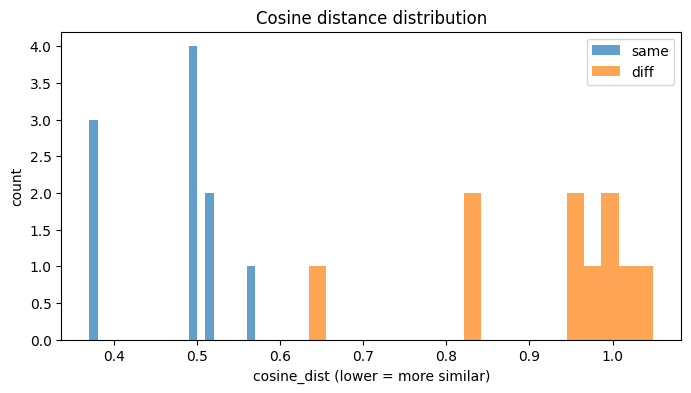

same mean: 0.47039382457733153
diff mean: 0.9252923178486526


In [91]:
ok = df[df["ok"] == True].copy()

same = ok[ok["label"] == "same"]["cosine_dist"].astype(float)
diff = ok[ok["label"] == "diff"]["cosine_dist"].astype(float)

plt.figure(figsize=(8,4))
plt.hist(same, bins=20, alpha=0.7, label="same")
plt.hist(diff, bins=20, alpha=0.7, label="diff")
plt.title("Cosine distance distribution")
plt.xlabel("cosine_dist (lower = more similar)")
plt.ylabel("count")
plt.legend()
plt.show()

print("same mean:", float(same.mean()) if len(same) else None)
print("diff mean:", float(diff.mean()) if len(diff) else None)


Гистограмма показывает чёткое разделение распределений, что говорит о корректной работе пайплайна.

**Вывод:** Поставленная задача по сборке полного пайплайна распознавания лиц реализована в полном объёме.

На вход пайплайна подаётся изображение, содержащее одно или несколько лиц.
На выходе формируются эмбеддинги всех детектированных лиц, пригодные для последующего сравнения и верификации.

В рамках реализации:

Для этапа детекции используется предобученный детектор лиц RetinaFace, реализованный в библиотеке InsightFace (набор моделей buffalo_l), обеспечивающий устойчивое обнаружение лиц на изображении.

Этап предсказания ключевых точек реализован с помощью Stacked Hourglass Network, обученной на задаче локализации ключевых точек лица.
Модель предсказывает 5 опорных точек, при этом для извлечения координат применяется метод soft-argmax.

Выравнивание лица выполняется на основе предсказанных ключевых точек с использованием similarity transform (алгоритм Umeyama).

Для извлечения признаков используется обученная модель ArcFace / CE, возвращающая нормализованные эмбеддинги фиксированной размерности.

Работа пайплайна продемонстрирована на парах изображений одного и разных людей с вычислением метрик сходства (cosine distance и L2 distance). Экспериментально показано, что расстояния между эмбеддингами изображений одного человека статистически меньше, чем для изображений разных людей, что подтверждает корректность и согласованность всех этапов пайплайна.